In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  #0 white 1 black 2 chinese 3 indian 4 hispanic
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import ToPILImage, ToTensor
import re
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report
import gc
torch.cuda.empty_cache()
gc.collect()

#for dirname, _, filenames in os.walk('/kaggle/input/utkface-new/UTKFace'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))   
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0

In [2]:
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [4]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

/kaggle/input/utkface-new/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [5]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,26.0,male,asian,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...
1,22.0,female,black,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...
2,21.0,female,indian,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...
3,28.0,male,white,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...
4,17.0,female,others,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...


In [6]:
# Under-sample the 'white' class
white_df = df[df['race'] == 'white']
non_white_df = df[df['race'] != 'white']

In [7]:
# Set the desired count, for instance, let's equalize it to the count of the 'black' class for demonstration purposes
desired_white_count = df[df['race'] == 'black'].shape[0]
white_df = white_df.sample(n=desired_white_count, random_state=42)

# Under-sample age values of 26
age_26_df = df[df['age'] == 26]
non_age_26_df = df[df['age'] != 26]

# Set the desired count, let's take the median of the age counts for demonstration
median_age_count = int(df['age'].value_counts().median())
age_26_df = age_26_df.sample(n=median_age_count, random_state=42)

In [8]:
# Concatenate the separate DataFrames back together
df = pd.concat([white_df, non_white_df, age_26_df, non_age_26_df])

In [9]:
# Shuffle the DataFrame rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
df.describe()

,age
count,39808.000000
mean,33.028311
std,19.960382
min,1.000000
25%,22.000000
50%,30.000000
75%,45.000000
max,116.000000


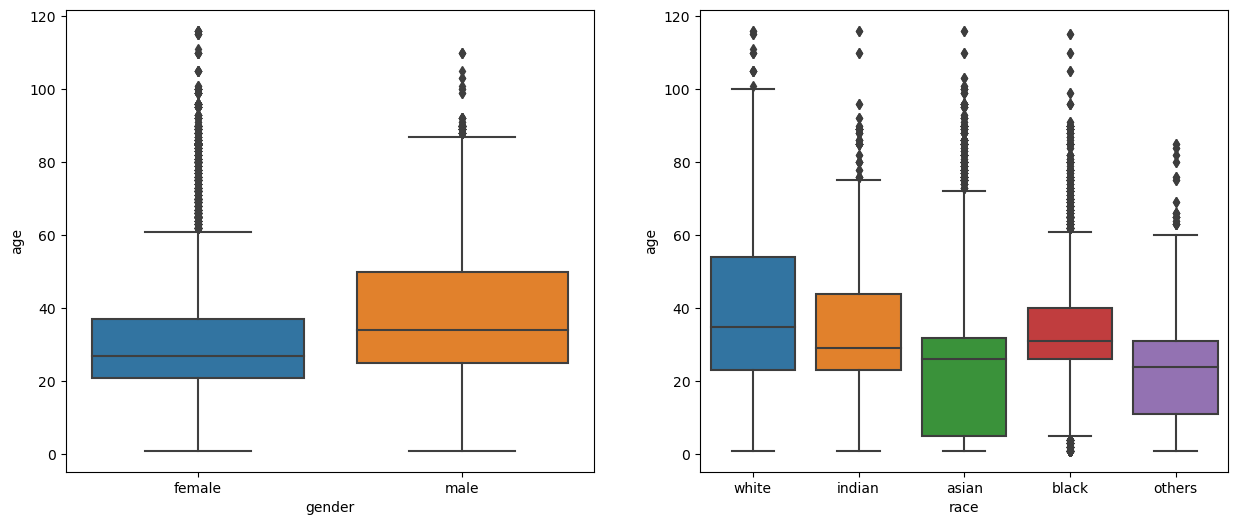

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

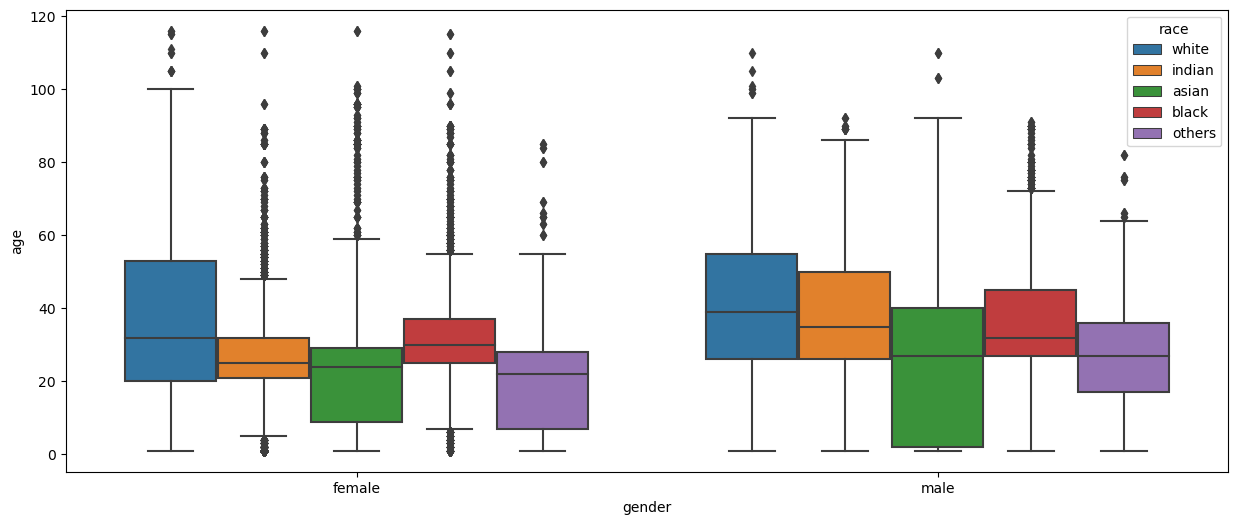

In [12]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

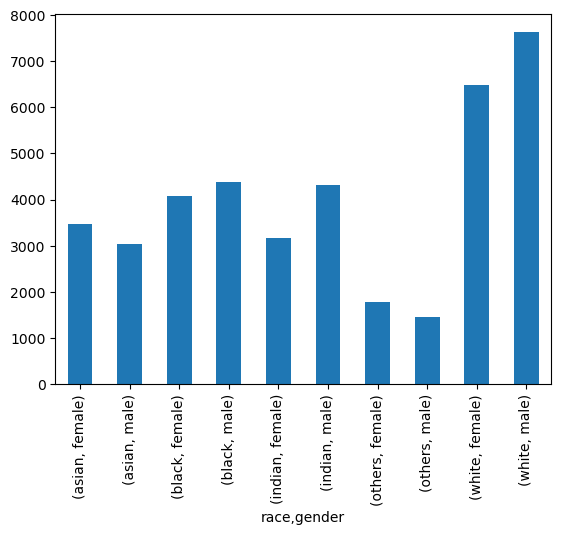

In [13]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<Axes: >

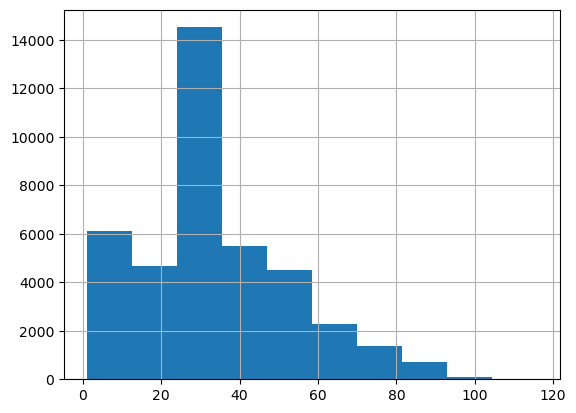

In [14]:
df['age'].hist()

In [15]:
df['age'].describe()
df = df[(df['age'] > 10) & (df['age'] < 70)]

In [16]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(15583, 6679, 9542, 69.0)

In [17]:
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 3]
        image = Image.open(img_name)
        age = self.df.iloc[idx, 0] / max_age
        race = torch.zeros(len(RACE_ID_MAP))
        race[self.df.iloc[idx, 5]] = 1
        gender = torch.zeros(2)
        gender[self.df.iloc[idx, 4]] = 1

        if self.transform:
            image = self.transform(image)

        return image, age, race, gender

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = UTKFaceDataset(df, transform)

train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(valid_idx))
test_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(test_idx))

In [40]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class EfficientNetB3Features(nn.Module):
#     def __init__(self, pretrained=True):
#         super(EfficientNetB3Features, self).__init__()
#         # Load the EfficientNet B3 model
#         model = models.efficientnet_b3(pretrained=pretrained)
#         # Remove the classifier layer
#         self.features = nn.Sequential(*list(model.children())[:-1])

#     def forward(self, x):
#         x = self.features(x)
#         return x

# class EfficientNetB3Model(nn.Module):
#     def __init__(self):
#         super(EfficientNetB3Model, self).__init__()
        
#         # Use EfficientNetB3 for feature extraction
#         self.backbone = EfficientNetB3Features(pretrained=True)

#         # For Age
#         self.age_cnn = nn.Sequential(
#             nn.Conv2d(1536, 192, kernel_size=3, padding=1),  # Adjusted the input channels
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1, 1))
#         )
#         self.fc1_age = nn.Linear(192, 1)

#         # For Race - assuming 5 races as an example
#         self.race_cnn = nn.Sequential(
#             nn.Conv2d(1536, 256, kernel_size=3, padding=1),  # Adjusted the input channels
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1, 1))
#         )
#         self.fc1_race = nn.Linear(256, 5)

#         # For Gender
#         self.gender_cnn = nn.Sequential(
#             nn.Conv2d(1536, 128, kernel_size=3, padding=1),  # Adjusted the input channels
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1, 1))
#         )
#         self.fc1_gender = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.backbone(x)

#         age_x = self.age_cnn(x)
#         age_x = torch.flatten(age_x, 1)
#         age = torch.sigmoid(self.fc1_age(age_x))

#         race_x = self.race_cnn(x)
#         race_x = torch.flatten(race_x, 1)
#         race = nn.functional.softmax(self.fc1_race(race_x), dim=1)

#         gender_x = self.gender_cnn(x)
#         gender_x = torch.flatten(gender_x, 1)
#         gender = nn.functional.softmax(self.fc1_gender(gender_x), dim=1)

#         return age, race, gender

# # Move model to device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = EfficientNetB3Model().to(device)
# model = model.float()

# # Loss and Optimizer
# criterion_age = nn.MSELoss()
# criterion_race = nn.CrossEntropyLoss()
# criterion_gender = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models

class EfficientNetB1Features(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNetB1Features, self).__init__()
        # Load the EfficientNet B1 model
        model = models.efficientnet_b1(pretrained=pretrained)
        # Remove the classifier layer
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x

class EfficientNetB1Model(nn.Module):
    def __init__(self):
        super(EfficientNetB1Model, self).__init__()
        
        # Use EfficientNetB1 for feature extraction
        self.backbone = EfficientNetB1Features(pretrained=True)

        # For Age
        self.age_cnn = nn.Sequential(
            nn.Conv2d(1280, 192, kernel_size=3, padding=1),  # Adjusted the input channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_age = nn.Linear(192, 1)

        # For Race - assuming 5 races as an example
        self.race_cnn = nn.Sequential(
            nn.Conv2d(1280, 256, kernel_size=3, padding=1),  # Adjusted the input channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_race = nn.Linear(256, 5)

        # For Gender
        self.gender_cnn = nn.Sequential(
            nn.Conv2d(1280, 128, kernel_size=3, padding=1),  # Adjusted the input channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_gender = nn.Linear(128, 2)

    def forward(self, x):
        x = self.backbone(x)

        age_x = self.age_cnn(x)
        age_x = torch.flatten(age_x, 1)
        age = torch.sigmoid(self.fc1_age(age_x))

        race_x = self.race_cnn(x)
        race_x = torch.flatten(race_x, 1)
        race = nn.functional.softmax(self.fc1_race(race_x), dim=1)

        gender_x = self.gender_cnn(x)
        gender_x = torch.flatten(gender_x, 1)
        gender = nn.functional.softmax(self.fc1_gender(gender_x), dim=1)

        return age, race, gender

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB1Model().to(device)
model = model.float()

# Loss and Optimizer
criterion_age = nn.MSELoss()
criterion_race = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 159MB/s]


In [19]:
# import time
# import matplotlib.pyplot as plt
# # Initialization
# num_epochs = 100

# # Lists to hold running losses for plotting
# running_loss_age = []
# running_loss_race = []
# running_loss_gender = []
# running_total_loss = []

# # Start the timer
# start_time = time.time()

# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss_age = 0
#     epoch_loss_race = 0
#     epoch_loss_gender = 0
#     epoch_total_loss = 0
#     total_samples = 0
    
#     for images, ages, races, genders in train_loader:
#         images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
#         optimizer.zero_grad()
#         age_preds, race_preds, gender_preds = model(images)
# #         print(age_preds.shape)
# #         print(race_preds.shape)
# #         print(gender_preds.shape)
#         age_preds = age_preds.squeeze(1)
#         loss_age = criterion_age(age_preds, ages)
#         loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
#         loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
#         loss = 2*loss_age + 1.5*loss_race + loss_gender  #Why are these values being multiplied?
#         loss = loss.float()
#         #print(loss)
#         loss.backward()
#         optimizer.step()
        
#         # Update the running losses
#         epoch_loss_age += loss_age.item() * len(images)
#         epoch_loss_race += loss_race.item() * len(images)
#         epoch_loss_gender += loss_gender.item() * len(images)
#         epoch_total_loss += loss.item() * len(images)
#         total_samples += len(images)
        
#     # Average the losses over the epoch
#     avg_loss_age = epoch_loss_age / total_samples
#     avg_loss_race = epoch_loss_race / total_samples
#     avg_loss_gender = epoch_loss_gender / total_samples
#     avg_total_loss = epoch_total_loss / total_samples

#     # Append the average losses for plotting later
#     running_loss_age.append(avg_loss_age)
#     running_loss_race.append(avg_loss_race)
#     running_loss_gender.append(avg_loss_gender)
#     running_total_loss.append(avg_total_loss)

#     # Print out the losses

#     print(f"Epoch [{epoch+1}/{num_epochs}] => Age Loss: {avg_loss_age:.9f}, Race Loss: {avg_loss_race:.9f}, Gender Loss: {avg_loss_gender:.9f}, Total Loss: {avg_total_loss:.9f}")

# # End the timer
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Training took {elapsed_time:.2f} seconds")

In [20]:
import time
import matplotlib.pyplot as plt

# Initialization
num_epochs = 100

# Lists to hold running losses for plotting
train_loss_age = []
train_loss_race = []
train_loss_gender = []
train_total_loss = []

# Lists to hold validation losses
valid_loss_age = []
valid_loss_race = []
valid_loss_gender = []
valid_total_loss = []

# Start the timer
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss_age = 0
    epoch_train_loss_race = 0
    epoch_train_loss_gender = 0
    epoch_train_total_loss = 0
    total_samples = 0
    
    for images, ages, races, genders in train_loader:
        images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
        optimizer.zero_grad()
        age_preds, race_preds, gender_preds = model(images)
        age_preds = age_preds.squeeze(1)
        
        loss_age = criterion_age(age_preds, ages)
        loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
        loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
        loss = 2*loss_age + 1.5*loss_race + loss_gender  
        
        loss.backward()
        optimizer.step()
        
        # Update the running losses
        epoch_train_loss_age += loss_age.item() * len(images)
        epoch_train_loss_race += loss_race.item() * len(images)
        epoch_train_loss_gender += loss_gender.item() * len(images)
        epoch_train_total_loss += loss.item() * len(images)
        total_samples += len(images)
    
    # Compute validation loss
    model.eval()
    epoch_valid_loss_age = 0
    epoch_valid_loss_race = 0
    epoch_valid_loss_gender = 0
    epoch_valid_total_loss = 0
    valid_samples = 0
    
    with torch.no_grad():
        for images, ages, races, genders in valid_loader:
            images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
            
            age_preds, race_preds, gender_preds = model(images)
            age_preds = age_preds.squeeze(1)
            
            loss_age = criterion_age(age_preds, ages)
            loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
            loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
            loss = 2*loss_age + 1.5*loss_race + loss_gender 
            
            epoch_valid_loss_age += loss_age.item() * len(images)
            epoch_valid_loss_race += loss_race.item() * len(images)
            epoch_valid_loss_gender += loss_gender.item() * len(images)
            epoch_valid_total_loss += loss.item() * len(images)
            valid_samples += len(images)
    
    # Average the losses over the epoch for training
    avg_train_loss_age = epoch_train_loss_age / total_samples
    avg_train_loss_race = epoch_train_loss_race / total_samples
    avg_train_loss_gender = epoch_train_loss_gender / total_samples
    avg_train_total_loss = epoch_train_total_loss / total_samples
    
    # Average the losses over the epoch for validation
    avg_valid_loss_age = epoch_valid_loss_age / valid_samples
    avg_valid_loss_race = epoch_valid_loss_race / valid_samples
    avg_valid_loss_gender = epoch_valid_loss_gender / valid_samples
    avg_valid_total_loss = epoch_valid_total_loss / valid_samples
    
    # Append the average losses for plotting later (training)
    train_loss_age.append(avg_train_loss_age)
    train_loss_race.append(avg_train_loss_race)
    train_loss_gender.append(avg_train_loss_gender)
    train_total_loss.append(avg_train_total_loss)
    
    # Append the average losses for plotting later (validation)
    valid_loss_age.append(avg_valid_loss_age)
    valid_loss_race.append(avg_valid_loss_race)
    valid_loss_gender.append(avg_valid_loss_gender)
    valid_total_loss.append(avg_valid_total_loss)

    # Print out the losses for training and validation
    print(f"Epoch [{epoch+1}/{num_epochs}] => Train Age Loss: {avg_train_loss_age:.9f}, Train Race Loss: {avg_train_loss_race:.9f}, Train Gender Loss: {avg_train_loss_gender:.9f}, Train Total Loss: {avg_train_total_loss:.9f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] => Valid Age Loss: {avg_valid_loss_age:.9f}, Valid Race Loss: {avg_valid_loss_race:.9f}, Valid Gender Loss: {avg_valid_loss_gender:.9f}, Valid Total Loss: {avg_valid_total_loss:.9f}")

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds")

Epoch [1/100] => Train Age Loss: 0.023034944, Train Race Loss: 1.323626745, Train Gender Loss: 0.462925315, Train Total Loss: 2.494435331
Epoch [1/100] => Valid Age Loss: 0.017729195, Valid Race Loss: 1.192196359, Valid Gender Loss: 0.391577926, Valid Total Loss: 2.215330849
Epoch [2/100] => Train Age Loss: 0.017767257, Train Race Loss: 1.174947983, Train Gender Loss: 0.386915717, Train Total Loss: 2.184872211
Epoch [2/100] => Valid Age Loss: 0.014775321, Valid Race Loss: 1.134355388, Valid Gender Loss: 0.368052263, Valid Total Loss: 2.099135987
Epoch [3/100] => Train Age Loss: 0.015977782, Train Race Loss: 1.135549191, Train Gender Loss: 0.374469311, Train Total Loss: 2.109748666
Epoch [3/100] => Valid Age Loss: 0.013433138, Valid Race Loss: 1.109748139, Valid Gender Loss: 0.367872532, Valid Total Loss: 2.059361007
Epoch [4/100] => Train Age Loss: 0.014432965, Train Race Loss: 1.116091116, Train Gender Loss: 0.366711906, Train Total Loss: 2.069714510
Epoch [4/100] => Valid Age Loss: 0

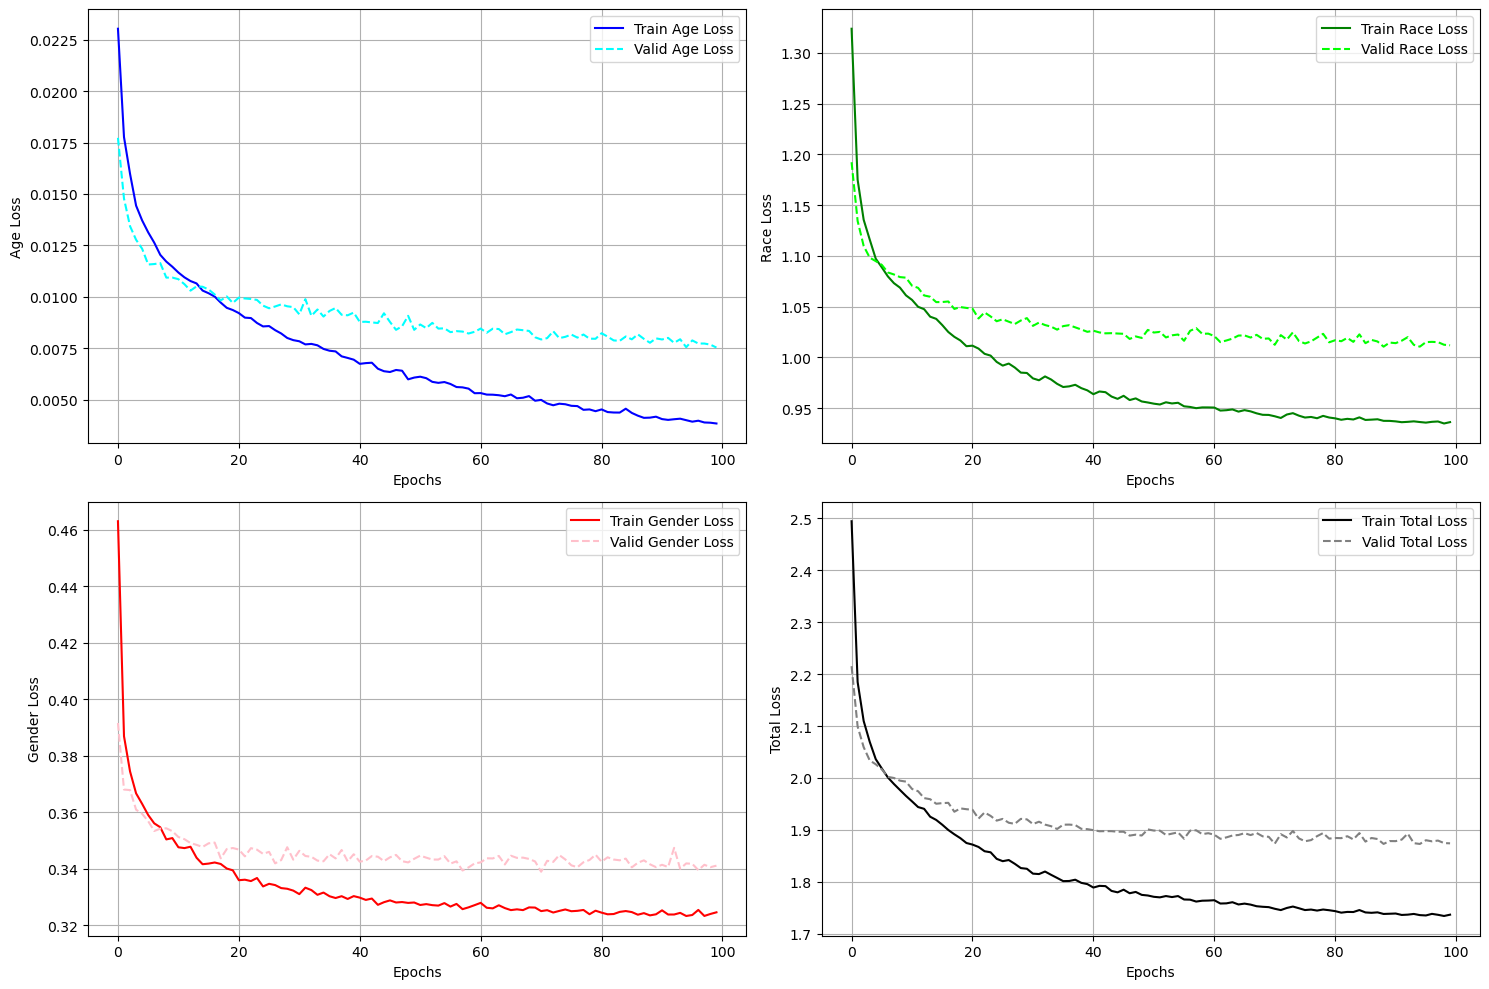

In [21]:
# Plotting the loss curves

plt.figure(figsize=(15, 10))

# Age Loss curve
plt.subplot(2, 2, 1)
plt.plot(train_loss_age, label='Train Age Loss', color='blue')
plt.plot(valid_loss_age, label='Valid Age Loss', color='cyan', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Age Loss')
plt.legend()
plt.grid(True)

# Race Loss curve
plt.subplot(2, 2, 2)
plt.plot(train_loss_race, label='Train Race Loss', color='green')
plt.plot(valid_loss_race, label='Valid Race Loss', color='lime', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Race Loss')
plt.legend()
plt.grid(True)

# Gender Loss curve
plt.subplot(2, 2, 3)
plt.plot(train_loss_gender, label='Train Gender Loss', color='red')
plt.plot(valid_loss_gender, label='Valid Gender Loss', color='pink', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Gender Loss')
plt.legend()
plt.grid(True)

# Total Loss curve
plt.subplot(2, 2, 4)
plt.plot(train_total_loss, label='Train Total Loss', color='black')
plt.plot(valid_total_loss, label='Valid Total Loss', color='gray', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

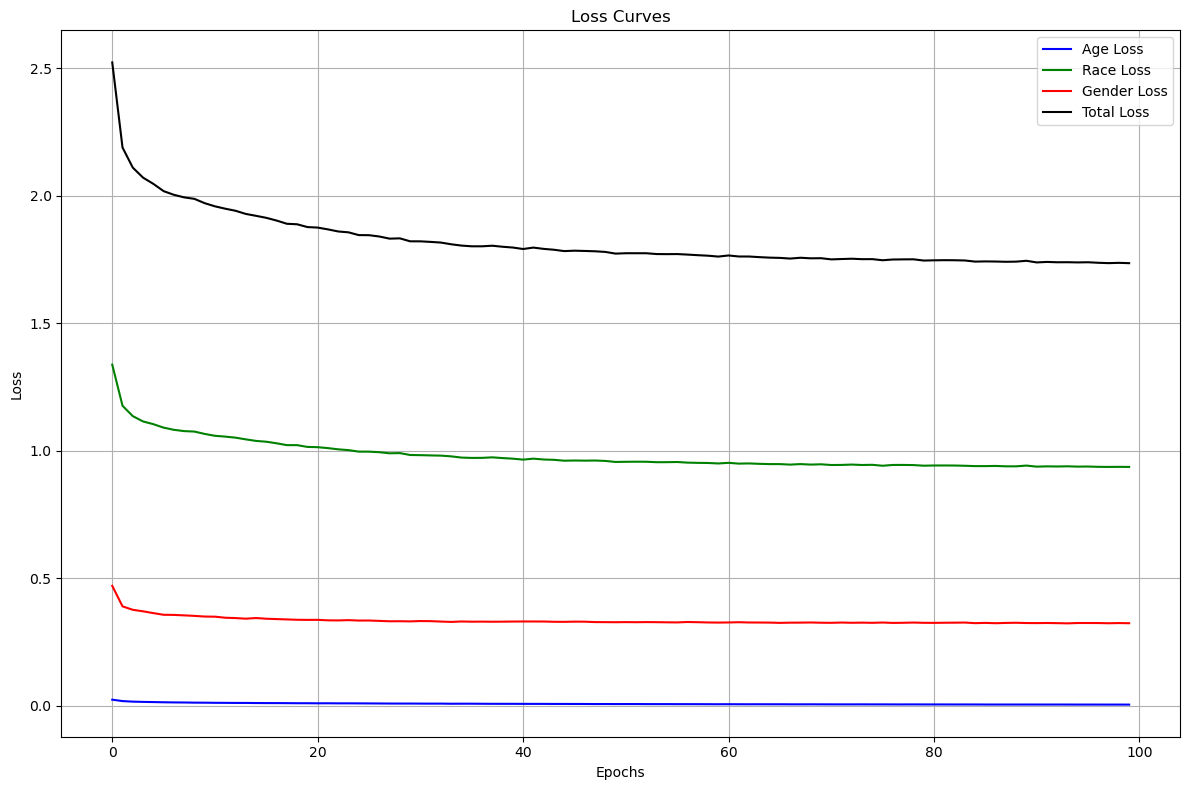

In [43]:
# # Plotting the loss curves

# plt.figure(figsize=(12, 8))

# # Age Loss curve
# plt.plot(running_loss_age, label='Age Loss', color='blue')
# # Race Loss curve
# plt.plot(running_loss_race, label='Race Loss', color='green')
# # Gender Loss curve
# plt.plot(running_loss_gender, label='Gender Loss', color='red')
# # Total Loss curve
# plt.plot(running_total_loss, label='Total Loss', color='black')

# # Setting x and y axis labels
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Curves')

# # Displaying the legend
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [22]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error

# Lists to store true labels and predictions
true_ages, pred_ages = [], []
true_races, pred_races = [], []
true_genders, pred_genders = [], []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, ages, races, genders in valid_loader:  # Assuming you have a validation loader called 'val_loader'
        images = images.float().to(device)

        # Get predictions
        age_preds, race_preds, gender_preds = model(images)

        # Convert predictions to class labels
        _, predicted_races = torch.max(race_preds, 1)
        _, predicted_genders = torch.max(gender_preds, 1)

        # Append true labels and predicted labels
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(age_preds.squeeze(1).cpu().numpy())

        true_races.extend(torch.argmax(races, dim=1).cpu().numpy())
        pred_races.extend(predicted_races.cpu().numpy())

        true_genders.extend(torch.argmax(genders, dim=1).cpu().numpy())
        pred_genders.extend(predicted_genders.cpu().numpy())

# Generate classification reports
print("Classification report for Age:")
print("True Ages:", true_ages[:10])
print("Predicted Ages:", pred_ages[:10])

# print("\nClassification report for Age:")
# print(classification_report(true_ages, pred_ages))

# Report for Age:
print("Report for Age:")
mae = mean_absolute_error(true_ages, pred_ages)
mse = mean_squared_error(true_ages, pred_ages)
print(f"Mean Absolute Error for Age: {mae:.4f}")
print(f"Mean Squared Error for Age: {mse:.4f}")

print("\nClassification report for Race:")
print(classification_report(true_races, pred_races))

print("\nClassification report for Gender:")
print(classification_report(true_genders, pred_genders))

Classification report for Age:
True Ages: [0.42028985507246375, 0.5072463768115942, 0.463768115942029, 0.5217391304347826, 0.43478260869565216, 0.4057971014492754, 0.7246376811594203, 0.2608695652173913, 0.34782608695652173, 0.8115942028985508]
Predicted Ages: [0.50016004, 0.5162414, 0.46006545, 0.42105567, 0.5195057, 0.47943643, 0.7285501, 0.34607348, 0.37325063, 0.8193282]
Report for Age:
Mean Absolute Error for Age: 0.0647
Mean Squared Error for Age: 0.0078

Classification report for Race:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2304
           1       0.94      0.92      0.93      1668
           2       0.92      0.93      0.92       905
           3       0.87      0.89      0.88      1277
           4       0.69      0.62      0.65       525

    accuracy                           0.89      6679
   macro avg       0.86      0.85      0.86      6679
weighted avg       0.89      0.89      0.89      6679


Classificati

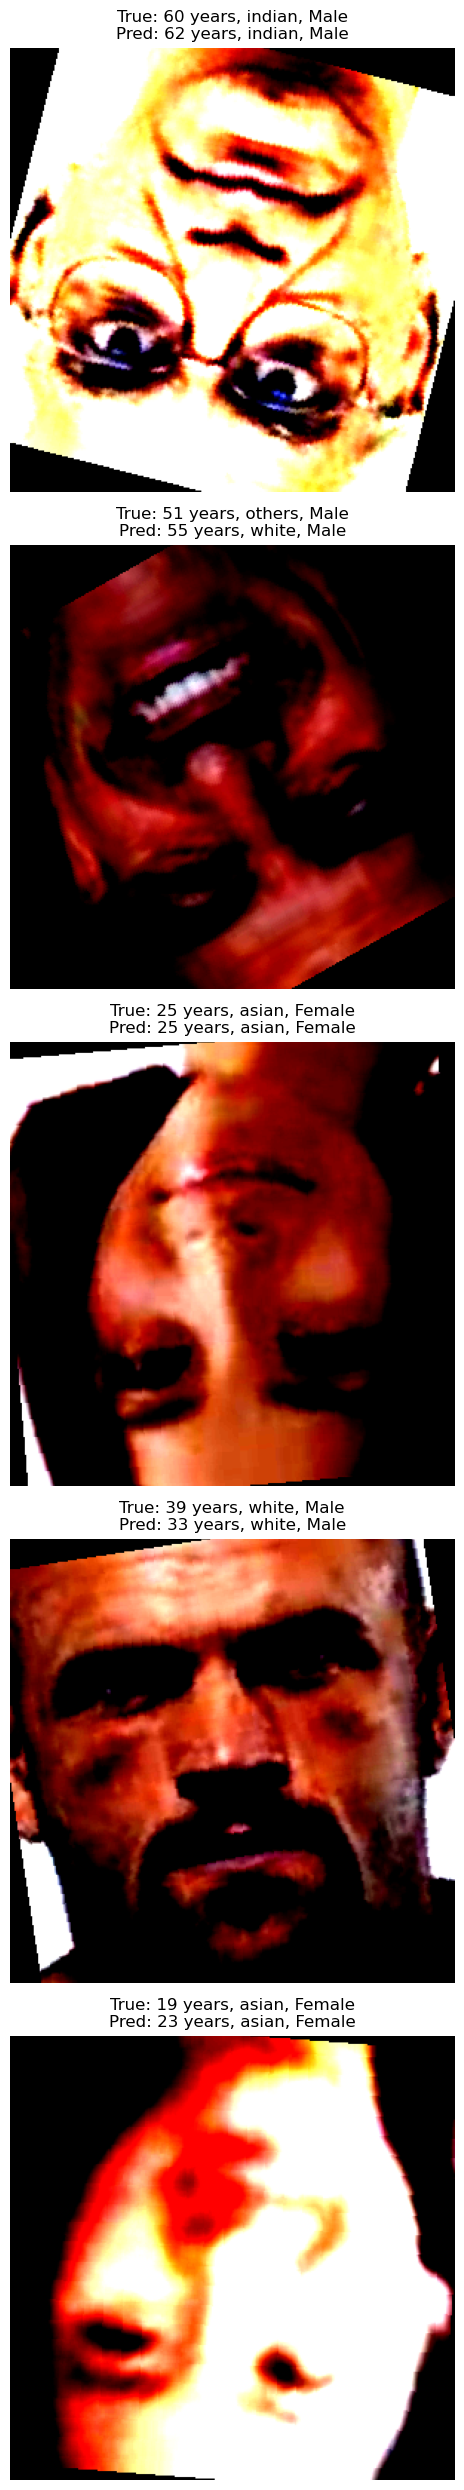

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    image_count = 0
    fig, axs = plt.subplots(num_images, figsize=(10, 5 * num_images))

    with torch.no_grad():
          for images, ages, races, genders in loader:
            if image_count >= num_images:
#         for idx, (images, ages, races, genders) in enumerate(loader):
#             if idx == num_images:
                break

            images = images.float().to(device)
            age_preds, race_preds, gender_preds = model(images)

            _, predicted_races = torch.max(race_preds, 1)
            _, predicted_genders = torch.max(gender_preds, 1)

            for i in range(images.size(0)):
                if image_count >= num_images:
                    break
            # Convert the predictions back to the label names
            pred_age = int(age_preds[i].squeeze().item() * max_age)
            true_age = int(ages[i].item() * max_age)

            # Assuming you have a reverse dictionary to map from label ID back to race name
#             pred_race = REVERSE_RACE_ID_MAP[predicted_races.item()]  
#             true_race = REVERSE_RACE_ID_MAP[torch.argmax(races, dim=1).item()]

            pred_race = ID_RACE_MAP[predicted_races[i].item()]
            true_race = ID_RACE_MAP[torch.argmax(races[i], dim=0).item()]


#             pred_gender = "Male" if predicted_genders.item() == 1 else "Female"
#             true_gender = "Male" if torch.argmax(genders, dim=1).item() == 1 else "Female"
            pred_gender = "Female" if predicted_genders[i].item() == 1 else "Male"
            true_gender = "Female" if torch.argmax(genders[i], dim=0).item() == 1 else "Male"
                
            # Plotting the image with predictions and true labels
#             axs[idx].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
#             axs[idx].axis('off')
#             axs[idx].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
            axs[image_count].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
            axs[image_count].axis('off')
            axs[image_count].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
                
            image_count += 1

    plt.tight_layout()
    plt.show()

# Visualize the predictions on the validation dataset
visualize_predictions(model, valid_loader)

In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 3]
        image = Image.open(img_name)
        age = self.df.iloc[idx, 0] / max_age
        race = torch.zeros(len(RACE_ID_MAP))
        race[self.df.iloc[idx, 5]] = 1
        gender = torch.zeros(2)
        gender[self.df.iloc[idx, 4]] = 1

        if self.transform:
            image = self.transform(image)

        return image, age, race, gender

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = UTKFaceDataset(df, transform)

train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(valid_idx))
test_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(test_idx))

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EfficientNetB1Features(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNetB1Features, self).__init__()
        # Load the EfficientNet B1 model
        model = models.efficientnet_b1(pretrained=pretrained)
        # Remove the classifier layer
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x

class EfficientNetB1Model(nn.Module):
    def __init__(self):
        super(EfficientNetB1Model, self).__init__()
        
        # Use EfficientNetB1 for feature extraction
        self.backbone = EfficientNetB1Features(pretrained=True)

        # For Age
        self.age_cnn = nn.Sequential(
            nn.Conv2d(1280, 192, kernel_size=3, padding=1),  # Adjusted the input channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_age = nn.Linear(192, 1)

        # For Race - assuming 5 races as an example
        self.race_cnn = nn.Sequential(
            nn.Conv2d(1280, 256, kernel_size=3, padding=1),  # Adjusted the input channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_race = nn.Linear(256, 5)

        # For Gender
        self.gender_cnn = nn.Sequential(
            nn.Conv2d(1280, 128, kernel_size=3, padding=1),  # Adjusted the input channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_gender = nn.Linear(128, 2)

    def forward(self, x):
        x = self.backbone(x)

        age_x = self.age_cnn(x)
        age_x = torch.flatten(age_x, 1)
        age = torch.sigmoid(self.fc1_age(age_x))

        race_x = self.race_cnn(x)
        race_x = torch.flatten(race_x, 1)
        race = nn.functional.softmax(self.fc1_race(race_x), dim=1)

        gender_x = self.gender_cnn(x)
        gender_x = torch.flatten(gender_x, 1)
        gender = nn.functional.softmax(self.fc1_gender(gender_x), dim=1)

        return age, race, gender

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB1Model().to(device)
model = model.float()

# Loss and Optimizer
criterion_age = nn.MSELoss()
criterion_race = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)